In [100]:
import numpy as np
import IPython
import scipy.io.wavfile
import scipy.signal as sig
import matplotlib.pyplot as plt

## Part 1

In [310]:
# STFT code from lab 1
from numpy.fft import rfft, irfft, fftfreq
def foward_transform(input_sound, dft_size, hop_size, zero_pad, window):
    input_len = len(input_sound)
    idx = 0
    segments = []
    while idx+dft_size < input_len:
        s = input_sound[idx:idx+dft_size]
        segments.append(np.multiply(s, window))
        idx += hop_size
    else:
        s = np.append(input_sound[idx:-1], np.zeros(idx+dft_size-input_len+1))
        segments.append(np.multiply(s, window))
    frames = np.array(segments)
    
    dft_frames = []
    for idx, x in enumerate(frames):
        dft_frames.append(rfft(x, dft_size + zero_pad))
    dft_frames = np.array(dft_frames, dtype=complex)
    return dft_frames 

def inverse_transform(input_sound, dft_size, hop_size, zero_pad, window):
    leng = hop_size*(len(input_sound)-1)+dft_size+zero_pad
    output = np.zeros(leng, dtype=complex)
    for idx, row in enumerate(input_sound):
        frame = np.multiply(irfft(row, dft_size + zero_pad), window)
        output[idx*hop_size:idx*hop_size+dft_size+zero_pad] += frame
    return output

def stft( input_sound, dft_size, hop_size, zero_pad, window):
    if input_sound.ndim == 1 and np.isreal(input_sound).all():
        return foward_transform(input_sound, dft_size, hop_size, zero_pad, window)
    else:
        return inverse_transform(input_sound, dft_size, hop_size, zero_pad, window)
    
def plot_stft( input_sound, stft, dft_size, hop_size, zero_pad, frate, title="", freq_top=frate/2):
    output = np.absolute(stft)**0.3
    time = np.linspace(0, len(input_sound)/frate, stft.shape[0])
    freq_num = int(freq_top//(frate/2/stft.shape[1])+1)
    freq = np.linspace(0, freq_top, freq_num)
    plt.pcolormesh(time, freq, output.T[:][:freq_num])
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (HZ)")
    plt.title(title)
    
def plot_sound( input_sound, fs, title='input_sound'):
    plt.plot(np.linspace(0, len(input_sound)/fs, len(input_sound)), input_sound)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.show()

##  First import the sound file

(445000,)


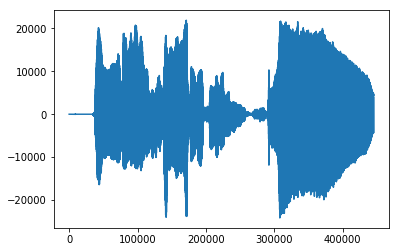

In [214]:
frate, file = scipy.io.wavfile.read("./data/beauty.wav")
IPython.display.display( IPython.display.Audio( file, rate=frate))
plt.plot(file)
print(file.shape)

###  Perform an STFT of the sound

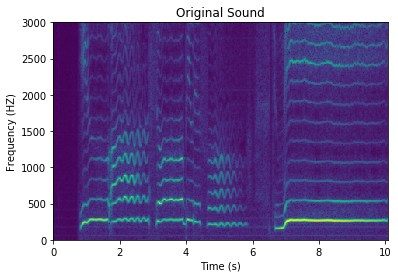

In [215]:
Hann_window = np.hanning(4096)
dft_size = 4096
hop_size = int(dft_size/4)
stft_out = stft(file, dft_size, hop_size, 0, Hann_window)
plot_stft(file, stft_out, dft_size, hop_size, 0, frate, "Original Sound", 3000)

## Extract the pitch from the stft 

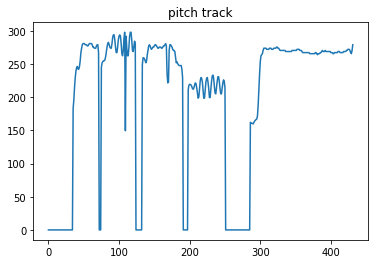

In [311]:
pitch = []
np.set_printoptions(threshold=np.nan)
for idx, DFT in enumerate(stft_out):
    row = DFT * np.conj(DFT)
    autocorrelation = irfft(row, dft_size)
    peaks = sig.find_peaks(autocorrelation[frate//300:frate//100])[0] + frate//300
    main_peak = autocorrelation[0]
    if max(autocorrelation[peaks]) > 0.7*main_peak:
        pitch.append(frate/peaks[np.argmax(autocorrelation[peaks])])
    else:
        pitch.append(0)
pitch = np.array(pitch)
plt.plot(pitch)
plt.title("pitch track")
plt.show()

### We can see that this is identical to the plot on the lecture slide except that I put zeros when there is no pitch. 

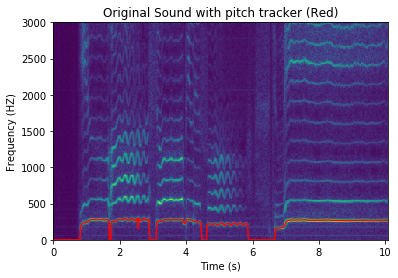

Now we can see the red line in the graph which tracks the pitch.


In [217]:
plot_stft(file, stft_out, dft_size, hop_size, 0, frate, "Original Sound with pitch tracker (Red)", 3000)
plt.plot(np.linspace(0,len(file)/frate, stft_out.shape[0]), pitch, color='red')
plt.show()
print("Now we can see the red line in the graph which tracks the pitch.")

## Part 2

In [305]:
def lowpass(f, fs):
    nyq = 0.5 * fs
    b, a = sig.butter(10, 340 / nyq, btype='lowpass', output = 'ba')
    return sig.filtfilt(b, a, f)

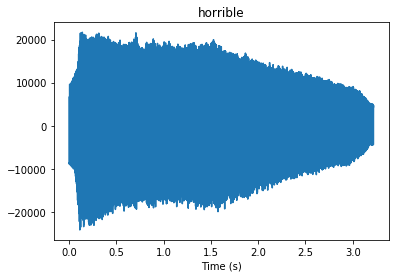

In [306]:
horrible = file[303000:445000]
plot_sound(horrible, frate, 'horrible')
IPython.display.display( IPython.display.Audio( horrible, rate=frate))

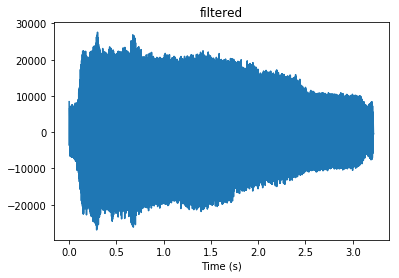

In [307]:
filtered = lowpass(horrible, frate)
plot_sound(filtered, frate, 'filtered')
IPython.display.display( IPython.display.Audio( filtered, rate=frate))

In [312]:
zero_crossing = np.where(np.diff(np.sign(filtered)))[0]
# solution found from https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python
periods = []
for idx in range(1, len(zero_crossing)-1):
    periods.append(horrible[zero_crossing[idx-1]:zero_crossing[idx+1]])

# Overlad add
output = np.zeros(filtered.shape)
for i in range( len(periods)):
    start = int((i) * frate / 274 / 2) + zero_crossing[0]
    if (start + len(periods[i]) < len(output)):
        output[start: start + len(periods[i])] += periods[i]*np.hanning(len(periods[i]))

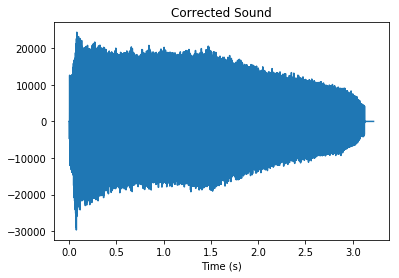

In [313]:
plot_sound(output, frate, 'Corrected Sound')
IPython.display.display( IPython.display.Audio( output, rate=frate))

### Now the 'Meeeeeeee' sounds much better in that the pitch does not fluctuate a lot.